# Model Training Notebook

In [1]:
# Requirements
# (update pip)
# fastai
# scikit-image

---

Package versions and available devices:

In [1]:
import fastai
import torch



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"fastai version : {fastai.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Number of GPUs : {torch.cuda.device_count()}")
print(f"Device         : {device}")

fastai version : 2.7.12
PyTorch version: 2.0.1
Number of GPUs : 0
Device         : cpu


In [2]:
from fastai.vision.all import *
from fastai.data.all import *

from pathlib import Path

In [3]:
import skimage.io

In [136]:
# RNG for frame selection
nprng = np.random.default_rng(123)

def imread2pil_train(fpath):
    '''
    read the middle frame and convert to PIL image.
    
    Image files should contain 3 channels.
    '''
    # use print to test datasets:
    # print(fpath)
    
    im = skimage.io.imread(str(fpath))
    
    # assuming images have 3 channels:
    if im.ndim<4:
        im = im[np.newaxis,...]
    
    # later need to add separate normalization for each channel,
    # now using only 2nd ch:CH1 of CH:0-2
    im = np.uint8( 255 * (im/im[...,1].max()) )
    
    # Filter
    # integrate CH1 along x-axis and find max inten-y ("nucleus")
    Iy = im[...,1].sum(axis=-1).argmax(axis=1)
    
    # frames w/ cells >10% away from the top/bottom edge
    mask = np.abs(Iy - im.shape[1]/2)/im.shape[1] < 0.4
    # if possible, select frames with nuclei away from the edge (visible)
    im = im[...,1][mask] if mask.any() else im[...,1] # only ch=1
    
    # Is est. avg location of nuclei on the top half (True)
    is_top = np.mean(Iy[mask] if mask.any() else Iy) < im.shape[1]/2 # False--> bottom
    
    # range of y-axis to remove empty region (e.g., if is_top==True, then remove bottom)
    y_ids = [0, min([224, im.shape[1]])] if is_top else [max([im.shape[1]-224, 0]), im.shape[1]]
    im = im[:,y_ids[0]:y_ids[1],:]
    
    if fpath.parents[1].name=="train":
        # select random frame if it's training data:
        frame_id = nprng.integers(im.shape[0])
    else:
        # for val data use middle frame
        frame_id = im.shape[0]//2
    return PILImage.create(im[frame_id])


def imread2pil_RGB(fpath):
    '''
    read the middle frame and convert to PIL image.
    
    Image files should contain 3 channels.
    '''
    # use print to test datasets:
    # print(fpath)
    
    im = skimage.io.imread(str(fpath))
    
    # assuming images have 3 channels:
    if im.ndim<4:
        im = im[np.newaxis,...]
    
    # 
    im = np.float_(im)
    for ch in [0,1]:
        im[...,ch] = 255 * im[...,ch] / im[...,ch].max()
    im[...,-1] = 0 # remove 3rd ch (=2)
    im = np.uint8(im) # to uint8 (RGB 8bit image)
    
    # Filter
    # integrate CH1 along x-axis and find max inten-y ("nucleus")
    Iy = im[...,1].sum(axis=-1).argmax(axis=1)
    
    # frames w/ cells >15% away from the top/bottom edge
    mask = np.abs(Iy - im.shape[1]/2)/im.shape[1] < 0.35
    # if possible, select frames with nuclei away from the edge (visible)
    im = im[mask] if mask.any() else im
    
    # Is est. avg location of nuclei on the top half (True)
    is_top = np.mean(Iy[mask] if mask.any() else Iy) < im.shape[1]/2 # False--> bottom
    
    # range of y-axis to remove empty region (e.g., if is_top==True, then remove bottom)
    y_ids = [0, min([224, im.shape[1]])] if is_top else [max([im.shape[1]-224, 0]), im.shape[1]]
    im = im[:,y_ids[0]:y_ids[1],...]
    
    if fpath.parents[1].name=="train":
        # select random frame if it's training data:
        frame_id = nprng.integers(im.shape[0])
    else:
        # for val data use middle frame
        frame_id = im.shape[0]//2
    return PILImage.create(im[frame_id])

---
A similar image loading func-n for the prediction stage:

In [5]:
def imread2pil(fpath):
    '''
    read the middle frame and convert to PIL image.
    
    Image files should contain 3 channels.
    '''
    # use print to test datasets:
    # print(fpath)
    
    im = skimage.io.imread(str(fpath))
    
    # assuming images have 3 channels:
    if im.ndim<4:
        im = im[np.newaxis,...]
    
    # later need to add separate normalization for each channel,
    # now using only 2nd ch:CH1 of CH:0-2
    im = np.uint8( 255 * (im/im[:,:,:,1].max()) )
    
    frame_id = im.shape[0]//2
    return PILImage.create(im[frame_id][:,:,1])

***Location of training dataset (main folder that contains "yes"/"no" folders)***:
> If the dataset is randomly split, e.g. 80% training and 20% validation, use seed for reproducibility, you need consistent train and val datasets to compare different models and training conditions.

- The original dataset contained images with either single channel. I manually removed these images into a separate folder.

- *Below, I assume all images have 3 channels*.

In [6]:
#
# data_path = Path('/mnt/mbi/images/micros/murat/dataDIR/maria_21072023/')
data_path = Path('../../dataDIR/maria_21072023/dataset/')

In [7]:
# fns = get_image_files(data_path)

In [62]:
# fpath = fns[10]

CH Imax= [87, 255, 0]


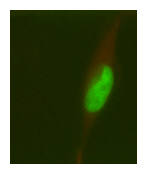

In [84]:
# im = skimage.io.imread(str(fpath))
# im = np.uint8(255*(im / im[...,1].max()))
# im[...,-1] = 0
# plt.figure(figsize=[2,2])
# plt.imshow( im[im.shape[0]//2] ); plt.axis(False);

# print('CH Imax=',[im[...,ch].max() for ch in range(im.shape[-1])])

In [97]:
# PILImage.create(im[im.shape[0]//2])

In [98]:
# im = skimage.io.imread(str(fpath))
# im = np.float_(im)
# for ch in [0,1]:
#     im[...,ch] = 255 * im[...,ch] / im[...,ch].max()
# im[...,-1] = 0

# im = np.uint8(im)
# im = im[:,50:200,...]

# plt.figure(figsize=[2,2])
# plt.imshow( im[im.shape[0]//2] ); plt.axis(False);

In [10]:
# im2 = Resize(224)(PILImage.create(im[0,...,1]))

In [137]:
cell_dataset = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                         get_items=get_image_files,
                         splitter=GrandparentSplitter(), # folder names: "train" / "valid"
                         get_x=imread2pil_RGB,
                         get_y=parent_label,
                         item_tfms = Resize(224) # Resize(224,method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
                        )

# debugging: use `cell_dataset.summary(data_path)`

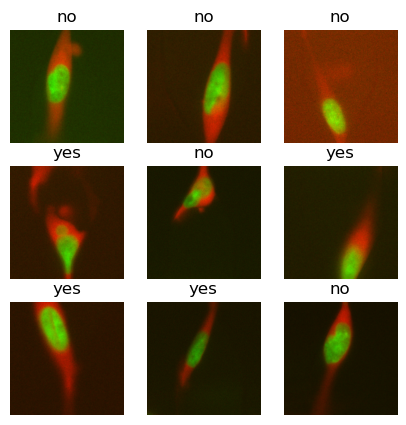

In [140]:
dls = cell_dataset.dataloaders(data_path)
dls.show_batch(max_n=9, figsize=(5,5))

In [14]:
print('Dataset sizes: \"train, val\"-->',[len(k) for k in dls.splits])

Dataset sizes: "train, val"--> [346, 88]


In [131]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/Users/muratshagirov/miniconda3/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/muratshagirov/miniconda3/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [132]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.305133,2.002388,1.000000,00:33


epoch,train_loss,valid_loss,error_rate,time
0,1.173888,1.502348,1.000000,00:18


In [20]:
# img_fns = get_image_files(data_path)
# pil_img_k = imread2pil(img_fns[230]); pil_img_k
# img_fns[230]

In [113]:
# # Need to use --> Resize(224)(input_img) to match training data
# learn.predict(Resize(224)(pil_img_k))

('no', tensor(0), tensor([0.9435, 0.0565]))

In [16]:
learn.save('./test')

Path('models/test.pth')

In [58]:
# Downloaded model weight are stored at:
# torch.hub.get_dir()
# e.g.
# ~/.cache/torch/hub/checkpoints # for Mac OS

In [44]:
# re-initialise the model with a downloaded model (trained on IMAGENET dataset)
# pre-trained models (torchhub): from torchvision.models import resnet34
# 
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [21]:
# load previously saved weights
learn.load('./test')

In [62]:
# continue training
#
# learn.fine_tune(...)